In [86]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math

# Decay functions

In [112]:
def linear_decay(start, end, t):
    return start + (end - start) * t

def exponential_decay(start, end, t):
    return start * (end / start) ** t

def cosine_annealing(start, end, t):
    return end + (start - end) * (1 + math.cos(math.pi * t)) / 2

def step_decay(start, end, t, num_steps=10):
    step_size = 1.0 / num_steps
    step_num = math.ceil(t / step_size)
    return start + (end - start) * step_num / num_steps

def sigmoid_decay(start, end, t):
    return start + (end - start) * (1 / (1 + math.exp(-10 * (t - 0.5))))

def polynomial_decay(start, end, t, power=2):
    return start + (end - start) * t ** power

def sinusoidal_decay(start, end, t):
    return end + (start - end) * (1 + math.sin(math.pi * t)) / 2

def constant_value(start, end, t):
    return start

# Monte-Carlo with epsilon-greedy policy

In [113]:
def monte_carlo(env, num_episodes=1000, epsilon_schedule=linear_decay, eps_start=1.0, eps_end=0.1, gamma=0.99999):
    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    counter = np.zeros((state_n, action_n))
    total_rewards_per_episode = []
    epsilons = []
    for episode in tqdm(range(num_episodes), desc="Monte Carlo"):
        epsilon = epsilon_schedule(eps_start, eps_end, episode/num_episodes)
        epsilons.append(epsilon)
        
        trajectory = {'states': [], 'actions': [], 'rewards': []}
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qfunction[state])

            next_state, reward, done, _ = env.step(action)

            trajectory['states'].append(state)
            trajectory['actions'].append(action)
            trajectory['rewards'].append(reward)

            total_reward += reward
            state = next_state

        total_rewards_per_episode.append(total_reward)

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1

    return total_rewards_per_episode, epsilons

# Setup

In [121]:
env = gym.make('Taxi-v3')
num_episodes = 10000

# Train

In [122]:
scheduling_functions = {
    'Linear Decay': linear_decay,
    'Exponential Decay': exponential_decay,
    'Cosine Annealing': cosine_annealing,
    'Step Decay': step_decay,
    'Sigmoid Decay': sigmoid_decay,
    'Polynomial Decay': polynomial_decay,
    'Sinusoidal Decay': sinusoidal_decay,
    'Constant Value': constant_value
}
rewards_all_schedules = []
epsilons_all_schedules = []
pbar = tqdm(scheduling_functions.items(), desc="Schedules")
for name, schedule in pbar:
    rewards, epsilons = monte_carlo(env, num_episodes=num_episodes, epsilon_schedule=schedule)
    epsilons_all_schedules.append((name, epsilons)) 
    rewards_all_schedules.append((name, rewards))
    pbar.set_postfix({name: round(np.mean(rewards[-20:]),1)})

Schedules:   0%|          | 0/8 [00:00<?, ?it/s]

Monte Carlo:   0%|          | 0/10000 [00:00<?, ?it/s]

Monte Carlo:   0%|          | 0/10000 [00:00<?, ?it/s]

Monte Carlo:   0%|          | 0/10000 [00:00<?, ?it/s]

Monte Carlo:   0%|          | 0/10000 [00:00<?, ?it/s]

Monte Carlo:   0%|          | 0/10000 [00:00<?, ?it/s]

Monte Carlo:   0%|          | 0/10000 [00:00<?, ?it/s]

Monte Carlo:   0%|          | 0/10000 [00:00<?, ?it/s]

Monte Carlo:   0%|          | 0/10000 [00:00<?, ?it/s]

# Plots and results

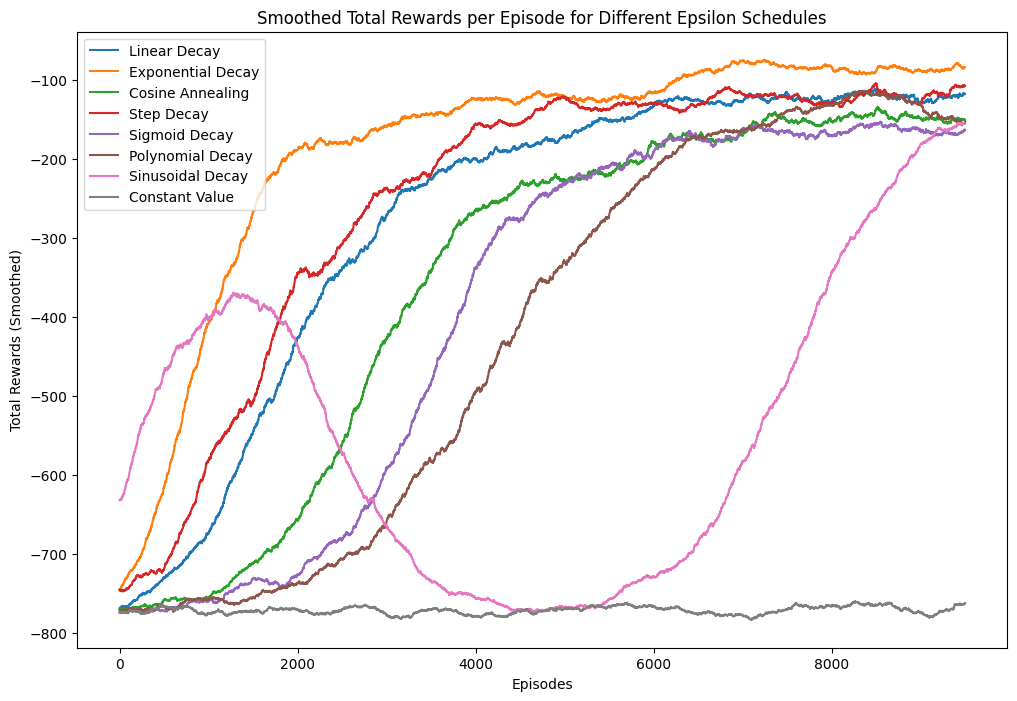

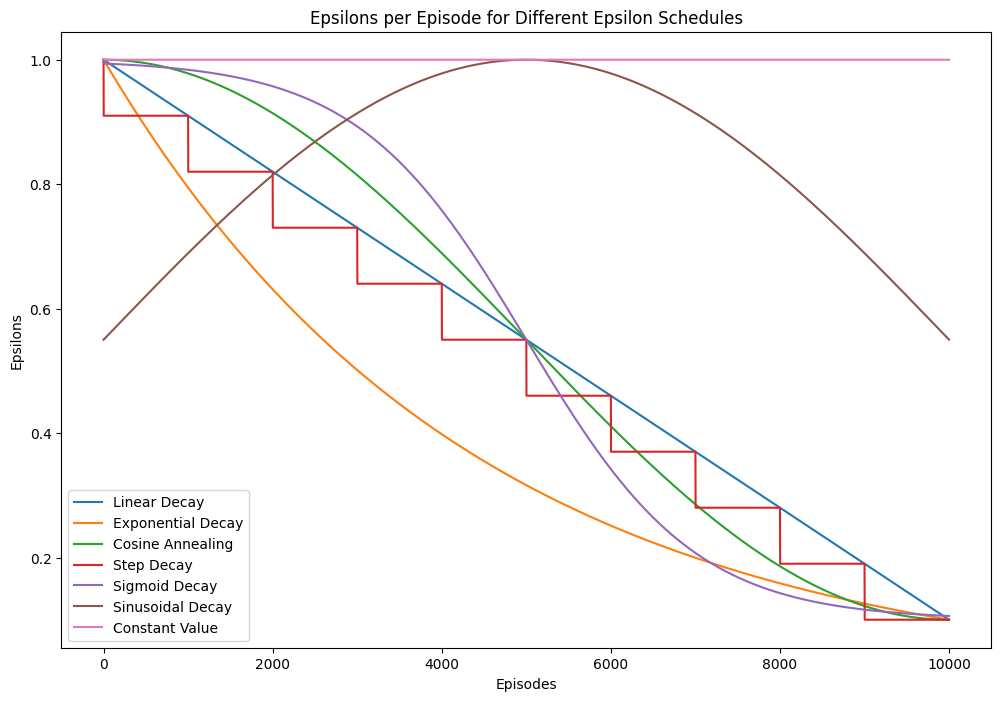

In [124]:
plt.figure(figsize=(12, 8))
for name, schedule_rewards in rewards_all_schedules:
    smoothed_rewards = np.convolve(schedule_rewards, np.ones(500)/500, mode='valid')
    plt.plot(smoothed_rewards, label=name)
plt.xlabel('Episodes')
plt.ylabel('Total Rewards (Smoothed)')
plt.title('Smoothed Total Rewards per Episode for Different Epsilon Schedules')
plt.legend()
plt.show()

# Plot epsilons with log scale
plt.figure(figsize=(12, 8))
for name, schedule_epsilons in epsilons_all_schedules:
    if "Poly" in name:
        continue
    plt.plot(schedule_epsilons, label=name)
plt.xlabel('Episodes')
plt.ylabel('Epsilons')
plt.title('Epsilons per Episode for Different Epsilon Schedules')
plt.legend()
plt.show()

# Analysis and conclusion 
Exponential decay allows Monte-Carlo epsilon-greedy policy to converge faster than the others, when applied to Taxi-v3 environment.